<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/3_Assorted_Interesting_Initial_Crypto_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interesting Intro Crypto Research

I want to look quickly at a few interesting ideas:
 - Day of week seasonality effects
 - Crypto returns following an FTX listing
 - Futures basis as a predictor of spot returns

 This is very rough... just quick idea testing.



In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate'), extra_dependencies = c())

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpdFKfuT/remotes8019b2468a/RWLab-rwRtools-1924b0b/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.33.tar.gz’



In [2]:
rwlab_data_auth()

Authorization successful!

In [3]:
perp <- crypto_get_futures()
funding <- crypto_get_perp_rates()
spot <- crypto_get_spot()


ℹ Downloading ftx_futures_ohlc_1h.feather

✔ Saved ftx_futures_ohlc_1h.feather to ftx/ftx_futures_ohlc_1h.feather  ( 232.4…





File successfully transferred


ℹ Downloading ftx_perpetual_funding_rates.feather

✔ Saved ftx_perpetual_funding_rates.feather to ftx/ftx_perpetual_funding_rates.…





File successfully transferred


ℹ Downloading ftx_spot_ohlc_1h.feather

✔ Saved ftx_spot_ohlc_1h.feather to ftx/ftx_spot_ohlc_1h.feather  ( 753.2 Mb )





File successfully transferred


# Day of Week (UTC) Seasonality

Do we see different behaviour conditional on day of the week?

In [4]:
spot %>%
  head()

ticker,date,open,high,low,close,volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1INCH/USD,2020-12-25 05:00:00,2.3956,2.9716,2.30955,2.5893,53413.45
1INCH/USD,2020-12-25 06:00:00,2.5893,2.6400,2.22560,2.5190,58925.92
1INCH/USD,2020-12-25 07:00:00,2.5190,2.8000,2.34990,2.6067,87704.12
1INCH/USD,2020-12-25 08:00:00,2.6067,2.7750,2.48290,2.6019,89654.50
1INCH/USD,2020-12-25 09:00:00,2.6019,2.7600,2.48210,2.6739,42066.59
1INCH/USD,2020-12-25 10:00:00,2.6739,2.9591,2.65150,2.7959,69676.92


In [5]:
universe <- c(
  'BTC/USD','ETH/USD','XRP/USD','BCH/USD','DOGE/USD','LINK/USD','LTC/USD',
  'RAY/USD','SOL/USD','FTT/USD','UNI/USD','SUSHI/USD','BNB/USD','MATIC/USD','SRM/USD', 'AAVE/USD')


In [6]:
dow_seasonality <- spot %>% 
  group_by(ticker) %>%
  mutate(
    year = lubridate::year(date),
    day_of_week = lubridate::wday(date), 
    logvolume = log(volume+1),
    c2c_logreturn = log(close/lag(close)),
    logrange = log(high/low)
  ) %>%
  na.omit() 

# Day of the Week Seasonality of Volume

We expect to see lower volume at weekends

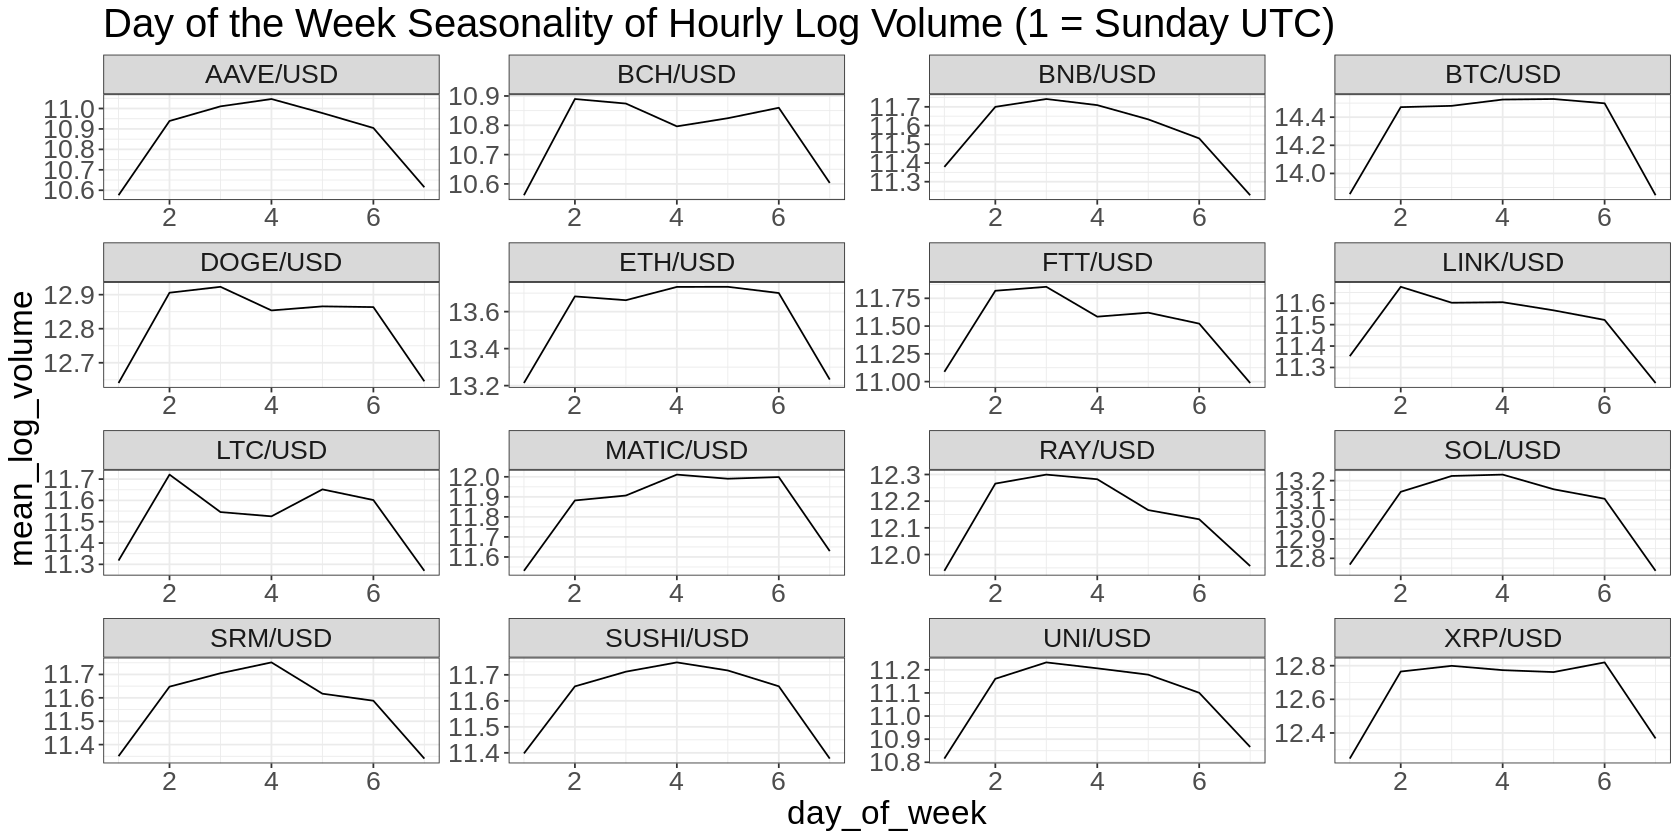

In [7]:
dow_seasonality %>%
  filter(ticker %in% universe) %>%
  group_by(ticker, day_of_week) %>%
  mutate(mean_log_volume = mean(logvolume)) %>%
  ggplot(aes(x=day_of_week, y=mean_log_volume)) +
  geom_line() +
  ggtitle('Day of the Week Seasonality of Hourly Log Volume (1 = Sunday UTC)') +
  facet_wrap(~ticker, scales = 'free') 

# Day of the Week Seasonality of Log Returns


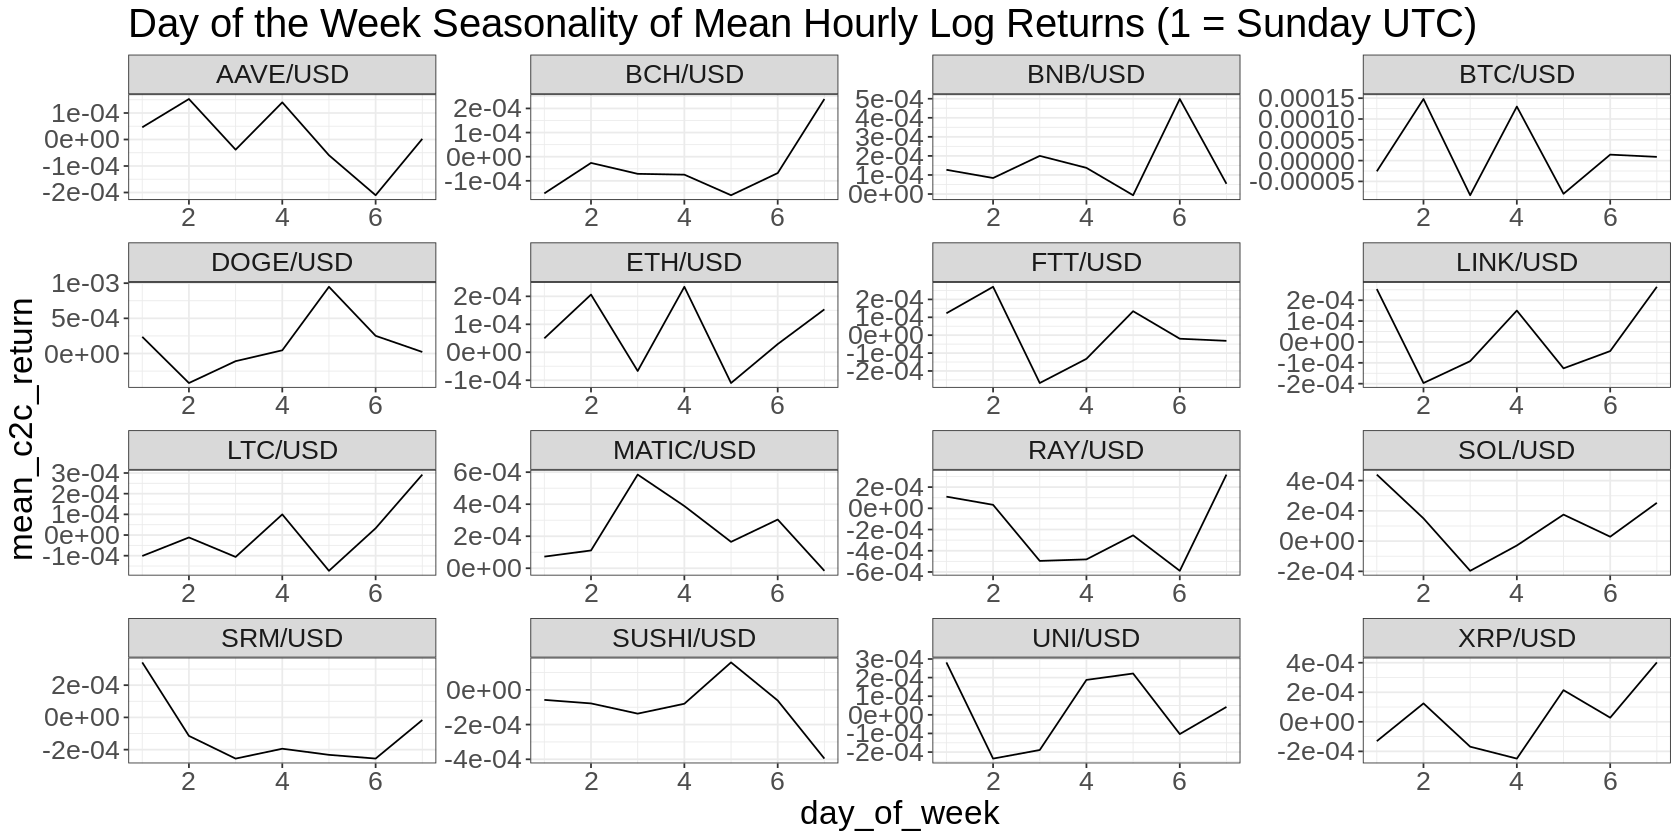

In [8]:
dow_seasonality %>%
  filter(ticker %in% universe) %>%
  group_by(ticker, day_of_week) %>%
  mutate(mean_c2c_return = mean(c2c_logreturn)) %>%
  ggplot(aes(x=day_of_week, y=mean_c2c_return)) +
  geom_line() +
  ggtitle('Day of the Week Seasonality of Mean Hourly Log Returns (1 = Sunday UTC)') +
  facet_wrap(~ticker, scales='free')

That zig-zag pattern that we see especially in BTC and ETH is fascinating. 


## BTC Day of Week Seasonal Effects

Let's see if it holds up on less data, by splitting by year.

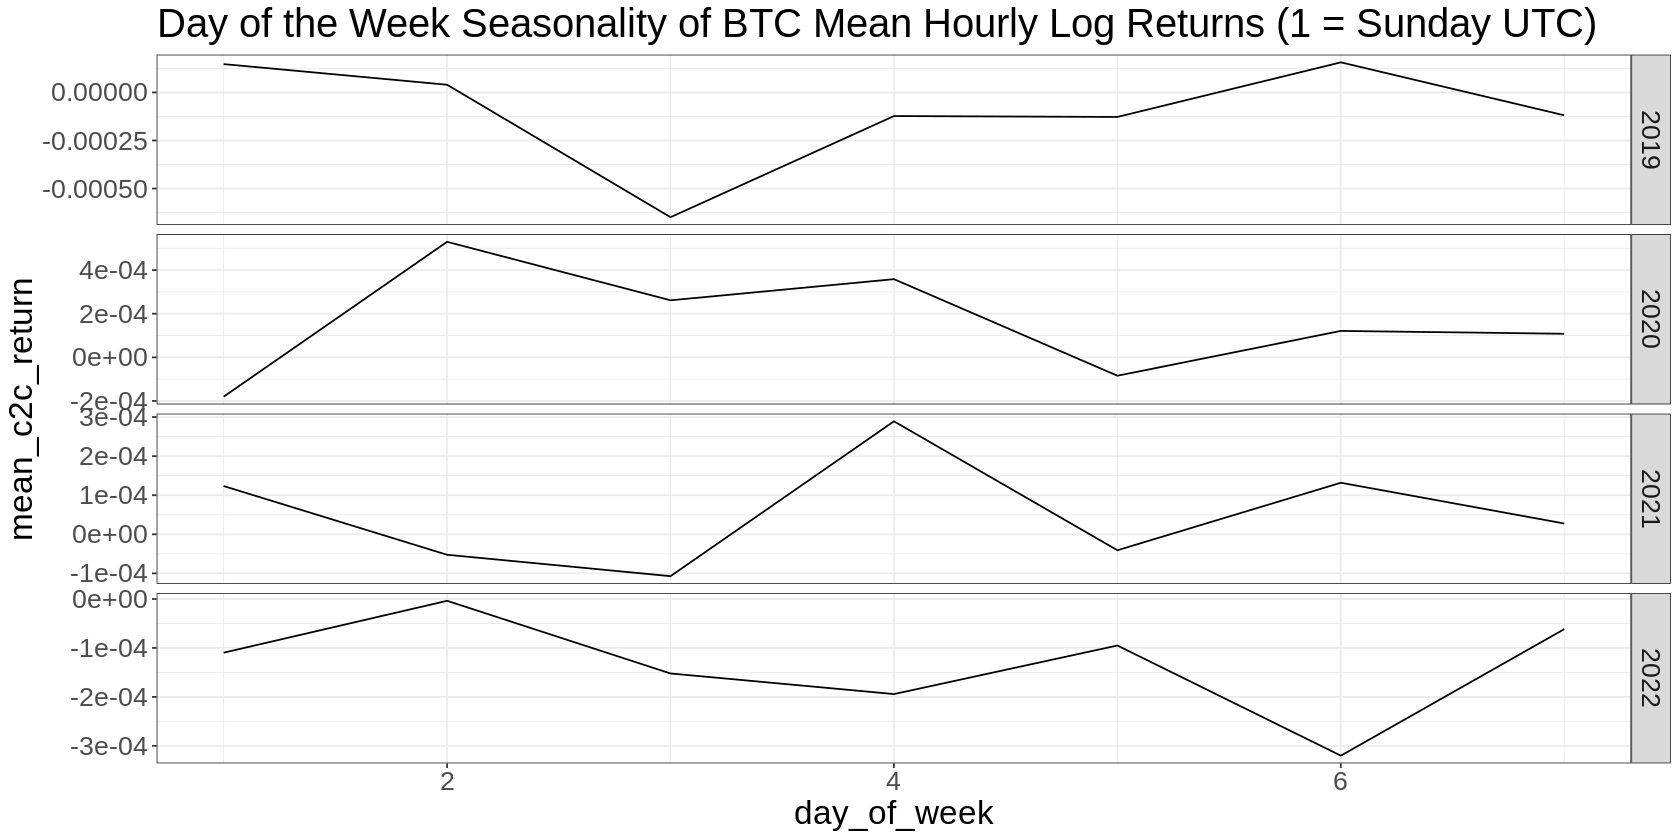

In [9]:
dow_seasonality %>%
  filter(ticker == 'BTC/USD') %>%
  group_by(ticker, year, day_of_week) %>%
  mutate(mean_c2c_return = mean(c2c_logreturn)) %>%
  ggplot(aes(x=day_of_week, y=mean_c2c_return)) +
  geom_line() +
  ggtitle('Day of the Week Seasonality of BTC Mean Hourly Log Returns (1 = Sunday UTC)') +
  facet_grid(rows= vars(year), scales='free')

And create some equity curves for "trading long on a given day of the week"

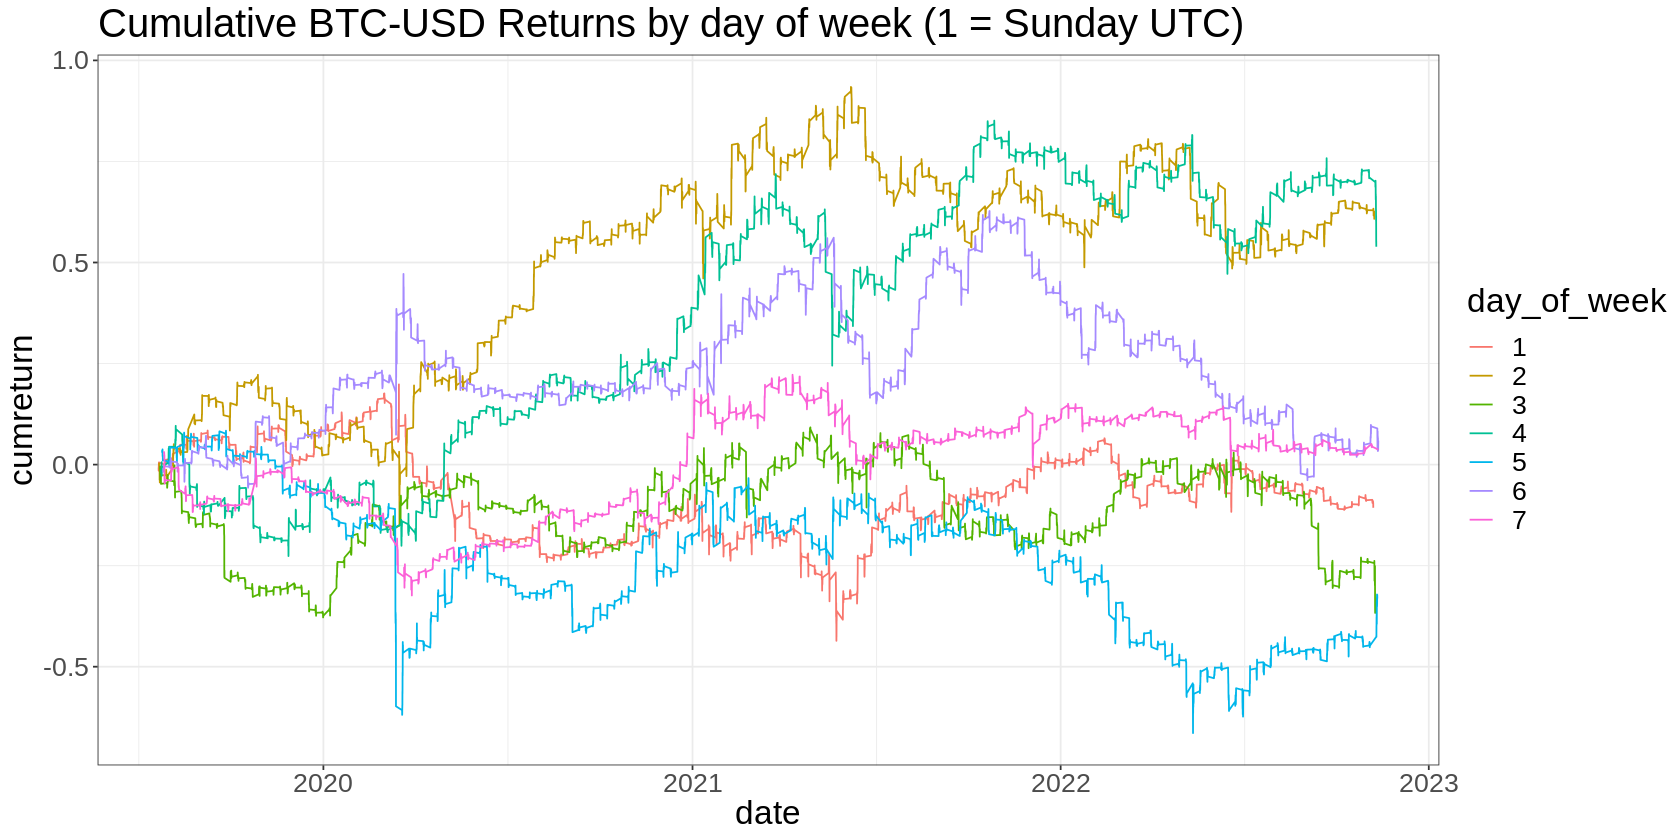

In [10]:
spot %>%
  filter(ticker == 'BTC/USD') %>%
  arrange(date) %>%
  mutate(
    day_of_week = factor(lubridate::wday(date)), 
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  group_by(day_of_week) %>%
  mutate(cumreturn = cumsum(c2c_logreturn)) %>%
  ggplot(aes(x=date, y=cumreturn, color=day_of_week)) + 
    geom_line() +
    ggtitle('Cumulative BTC-USD Returns by day of week (1 = Sunday UTC)')

## ETH Day of Week Seasonal Effects

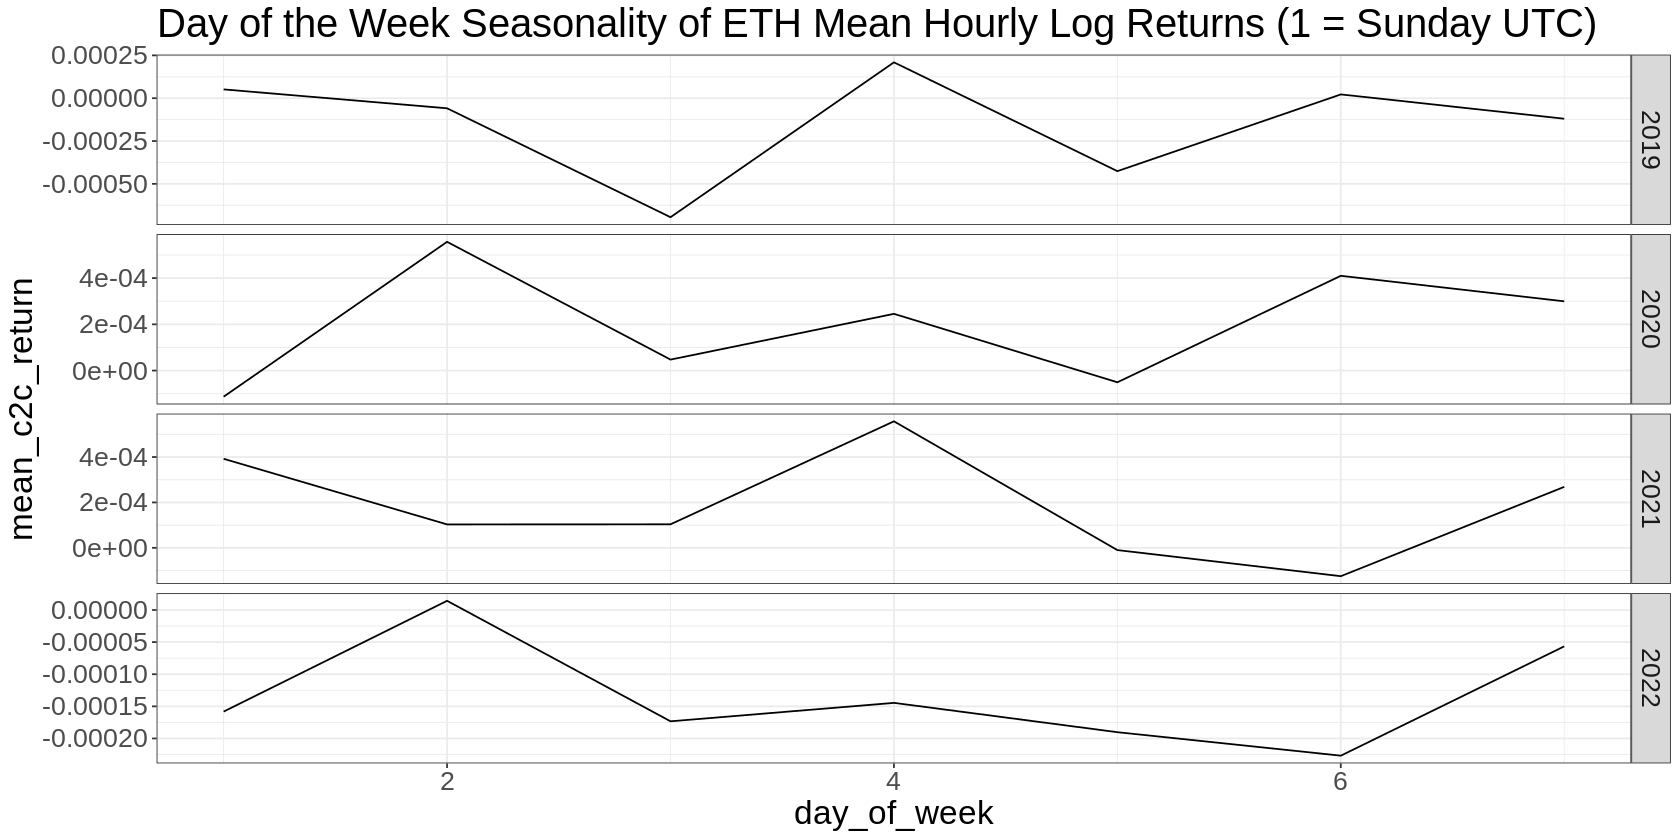

In [11]:
dow_seasonality %>%
  filter(ticker == 'ETH/USD') %>%
  group_by(ticker, year, day_of_week) %>%
  mutate(mean_c2c_return = mean(c2c_logreturn)) %>%
  ggplot(aes(x=day_of_week, y=mean_c2c_return)) +
  geom_line() +
  ggtitle('Day of the Week Seasonality of ETH Mean Hourly Log Returns (1 = Sunday UTC)') +
  facet_grid(rows= vars(year), scales='free')

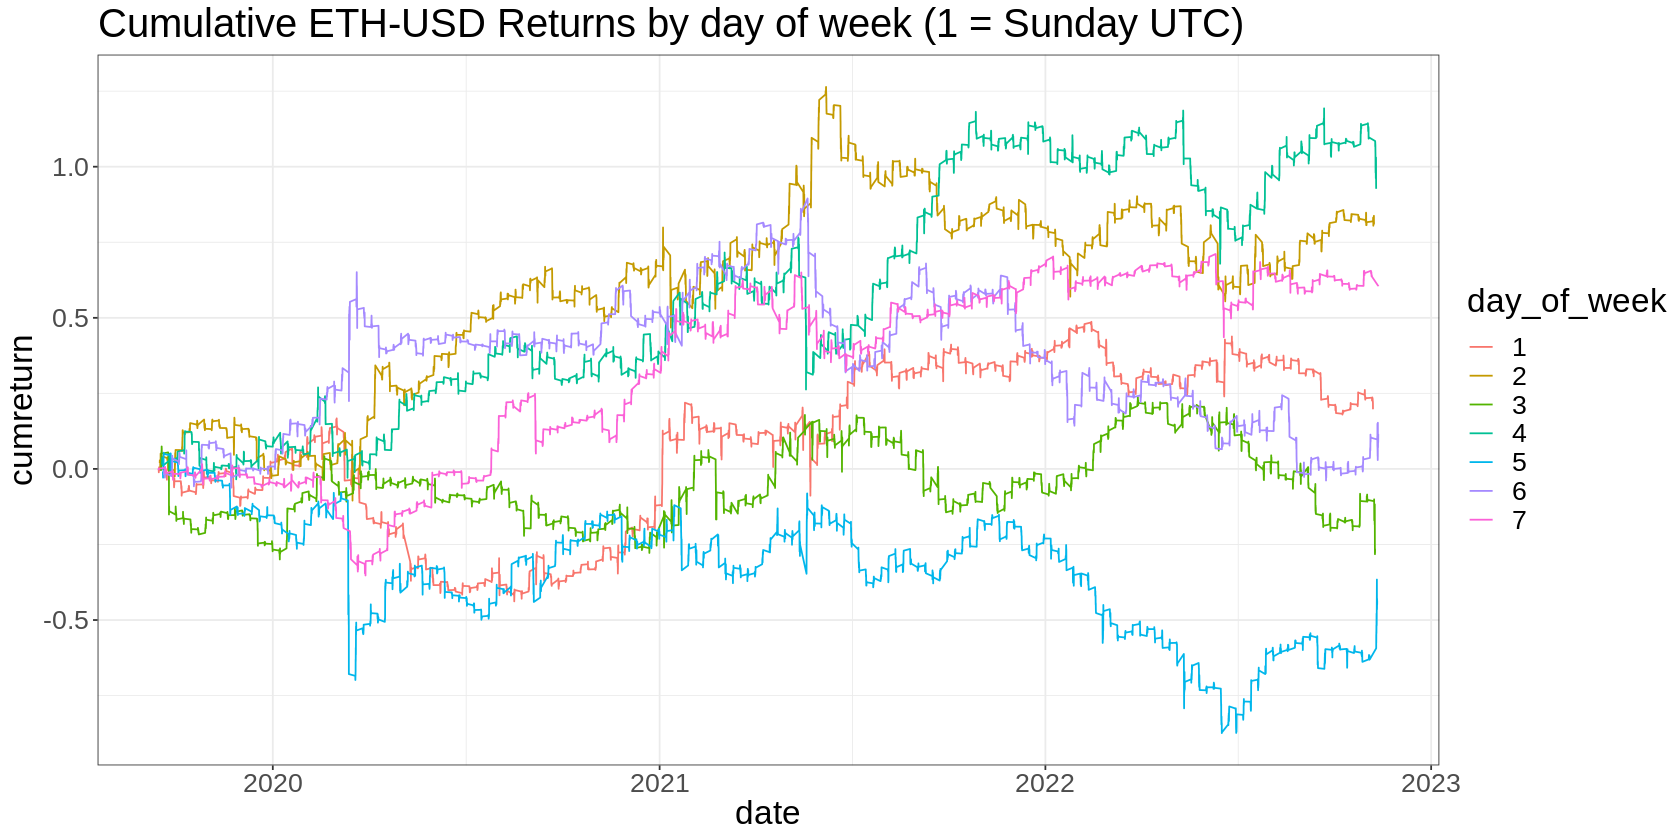

In [12]:
spot %>%
  filter(ticker == 'ETH/USD') %>%
  arrange(date) %>%
  mutate(
    day_of_week = factor(lubridate::wday(date)), 
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  group_by(day_of_week) %>%
  mutate(cumreturn = cumsum(c2c_logreturn)) %>%
  ggplot(aes(x=date, y=cumreturn, color=day_of_week)) + 
    geom_line() +
    ggtitle('Cumulative ETH-USD Returns by day of week (1 = Sunday UTC)')

## SOL + FTT Day of Week Seasonal Effects

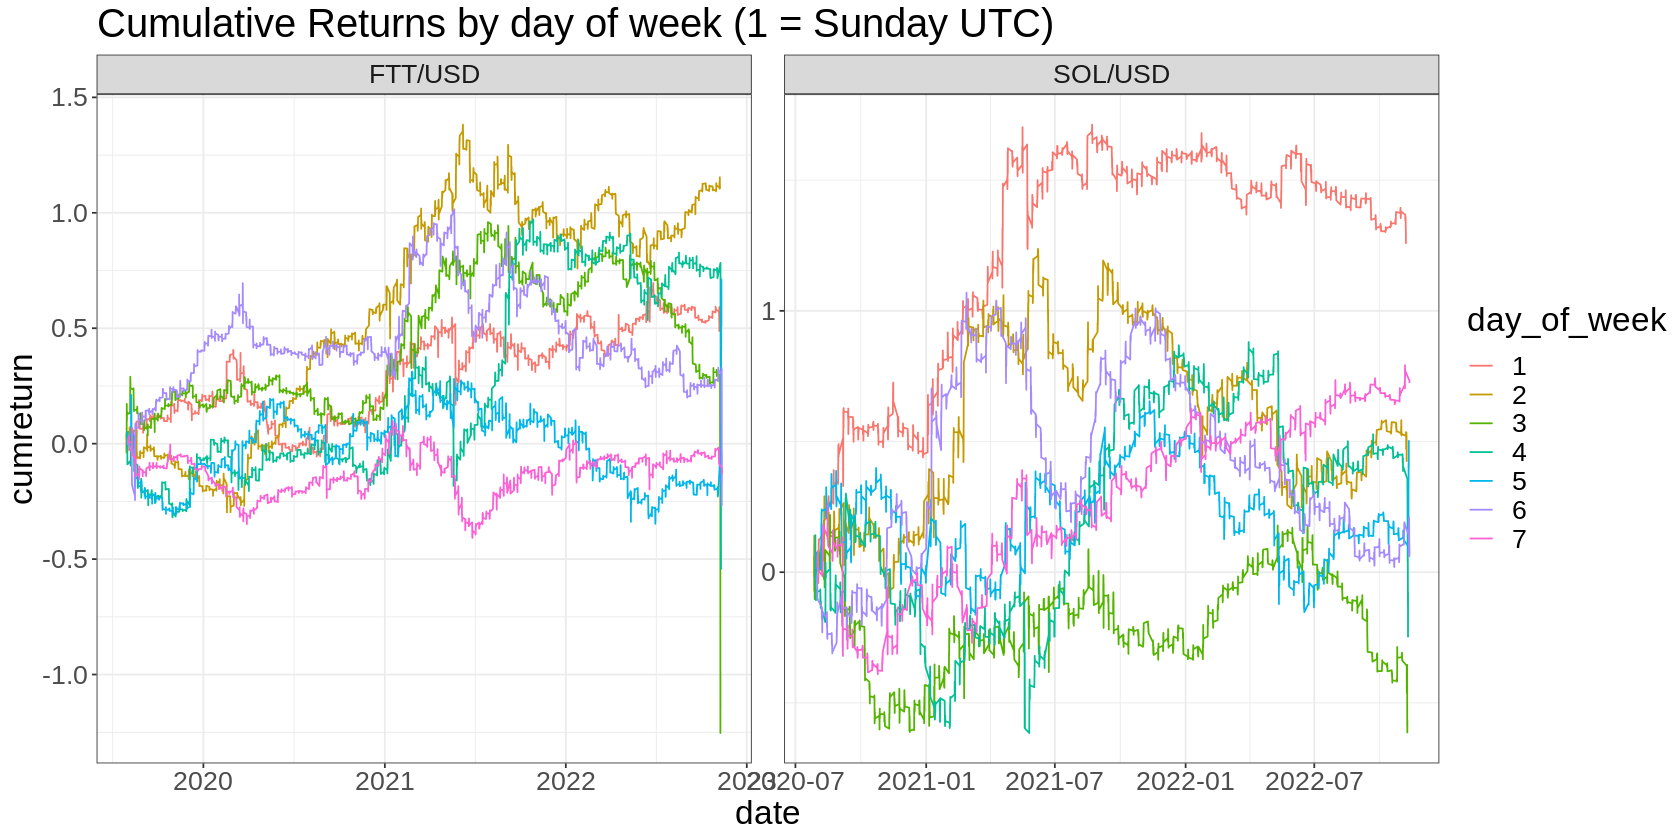

In [13]:
spot %>%
  filter(ticker %in% c('SOL/USD','FTT/USD')) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    day_of_week = factor(lubridate::wday(date)), 
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  group_by(ticker, day_of_week) %>%
  mutate(cumreturn = cumsum(c2c_logreturn)) %>%
  ggplot(aes(x=date, y=cumreturn, color=day_of_week)) + 
    geom_line() +
    ggtitle('Cumulative Returns by day of week (1 = Sunday UTC)') +
    facet_wrap(~ticker, scales = 'free')
    

"Ape SOL in Sunday" is interesting.

If I wanted to pump something, I might do it on a day where volume was lowest...



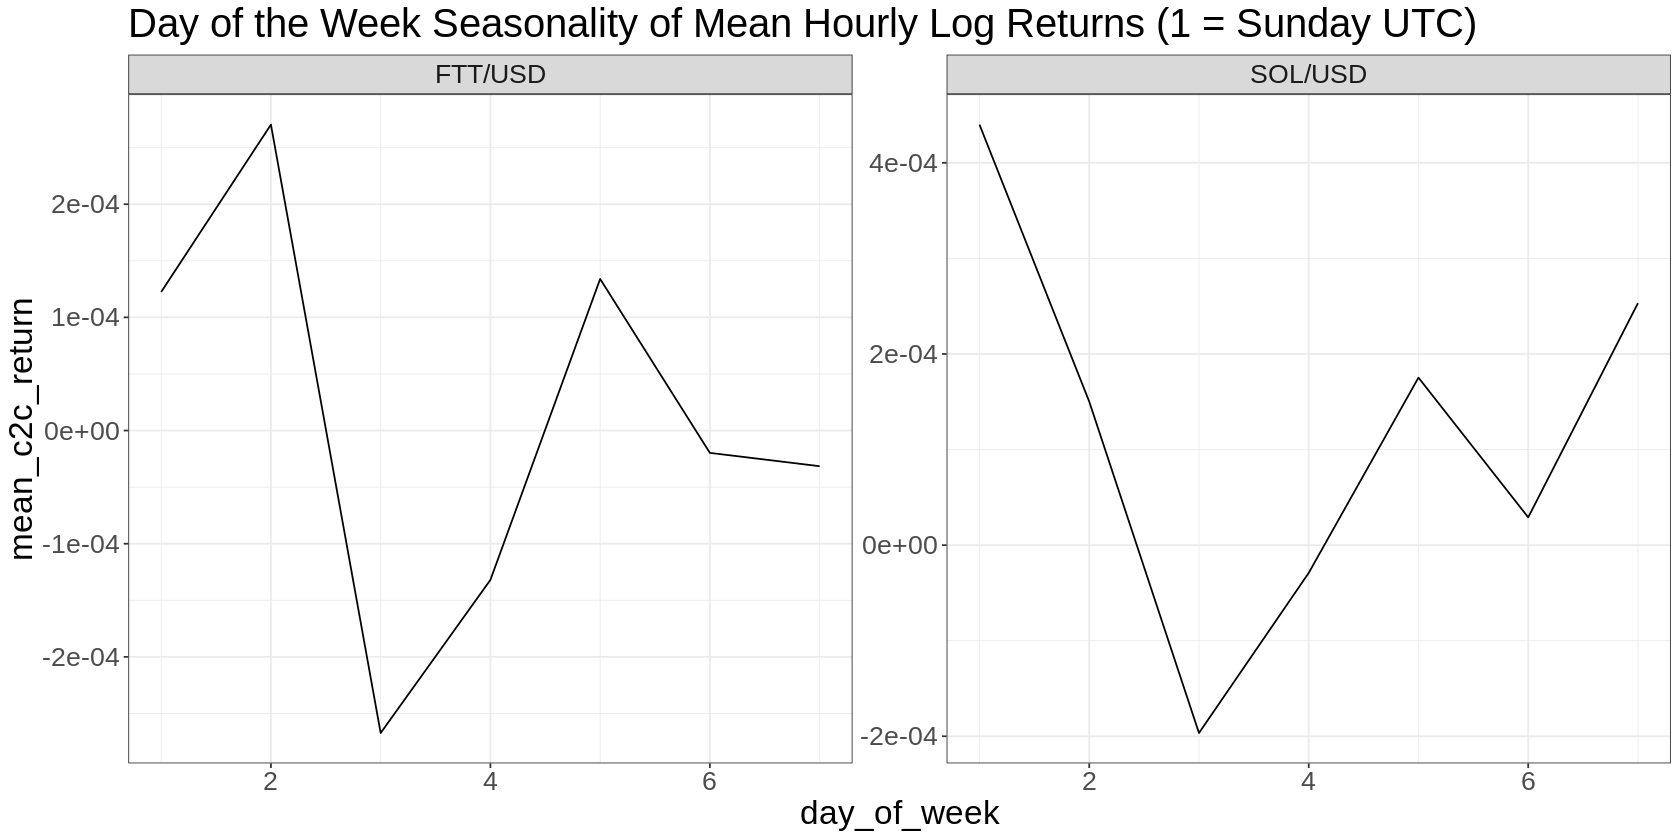

In [14]:
dow_seasonality %>%
  filter(ticker %in% c('FTT/USD','SOL/USD')) %>%
  group_by(ticker, day_of_week) %>%
  mutate(mean_c2c_return = mean(c2c_logreturn)) %>%
  ggplot(aes(x=day_of_week, y=mean_c2c_return)) +
  geom_line() +
  ggtitle('Day of the Week Seasonality of Mean Hourly Log Returns (1 = Sunday UTC)') +
  facet_wrap(~ticker, scales='free')

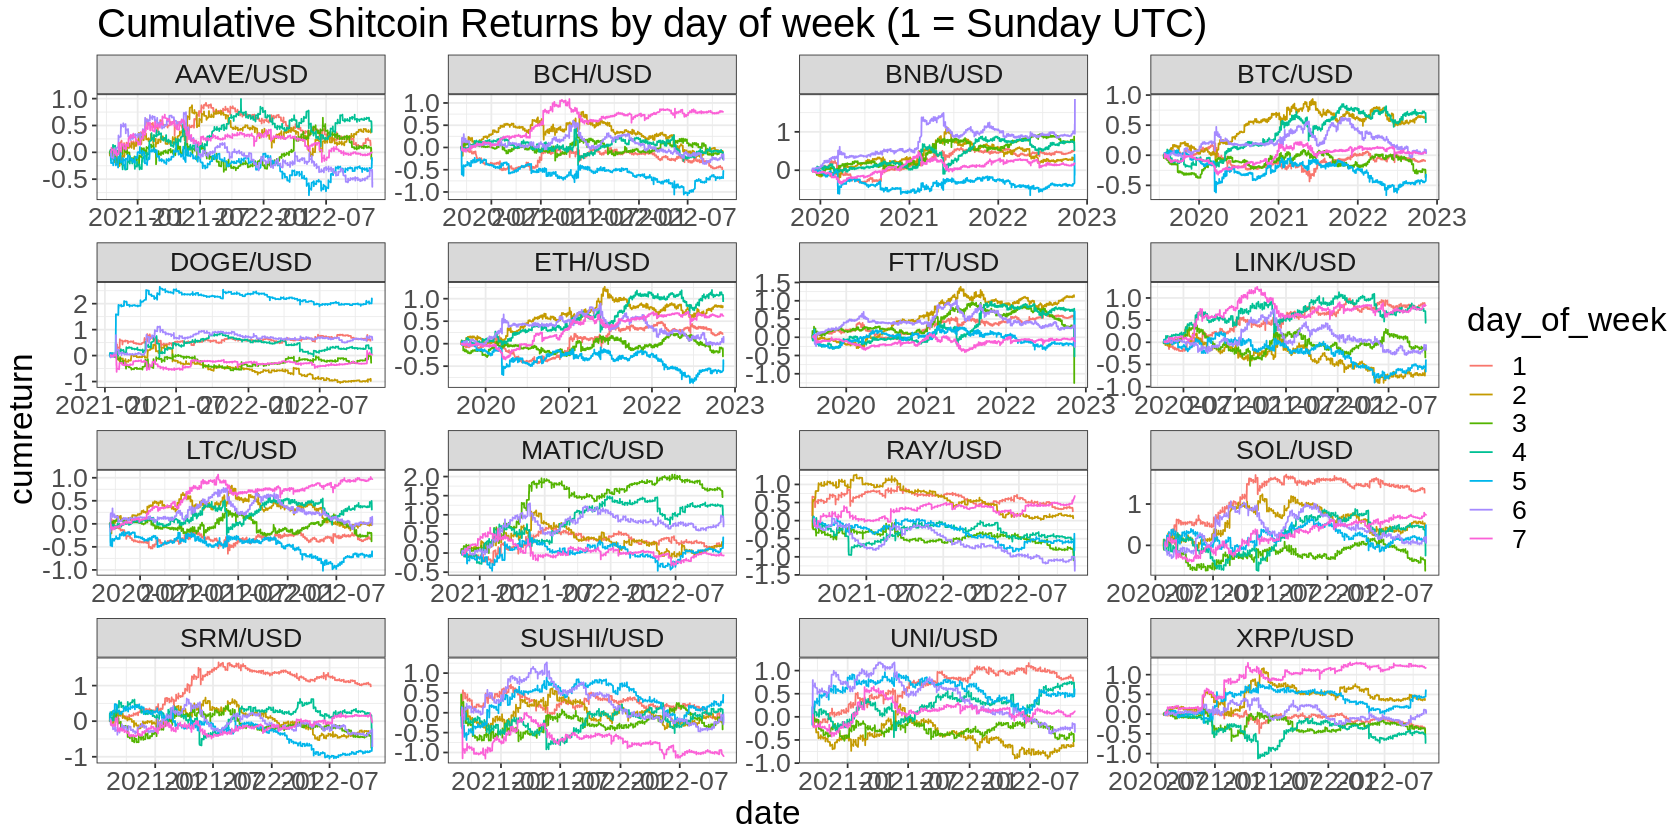

In [15]:
spot %>%
  filter(ticker %in% universe) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    day_of_week = factor(lubridate::wday(date)), 
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  group_by(ticker, day_of_week) %>%
  mutate(cumreturn = cumsum(c2c_logreturn)) %>%
  ggplot(aes(x=date, y=cumreturn, color=day_of_week)) + 
    geom_line() +
    ggtitle('Cumulative Shitcoin Returns by day of week (1 = Sunday UTC)') +
    facet_wrap(~ticker, scales = 'free')

# Day of Week Seasonality of Volatility

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


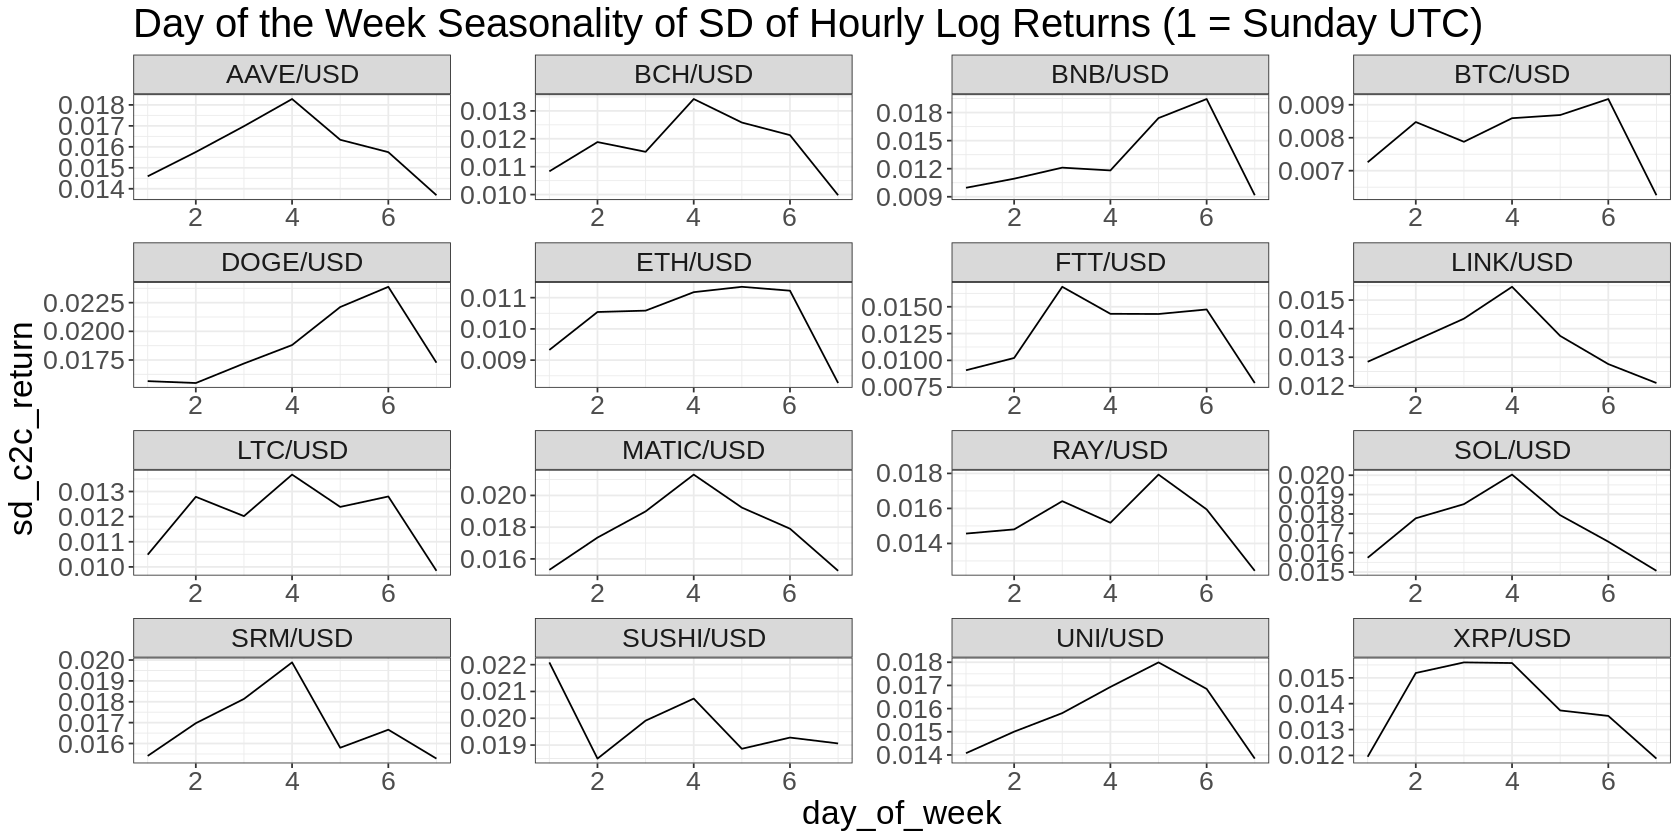

In [16]:
dow_seasonality %>%
  filter(ticker %in% universe) %>%
  group_by(ticker, day_of_week) %>%
  summarise(sd_c2c_return = sd(c2c_logreturn)) %>%
  ggplot(aes(x=day_of_week, y=sd_c2c_return)) +
  geom_line() +
  ggtitle('Day of the Week Seasonality of SD of Hourly Log Returns (1 = Sunday UTC)') +
  facet_wrap(~ticker, scales='free')


For Bitcoin, Friday is about twice as volatile as Saturday.


`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


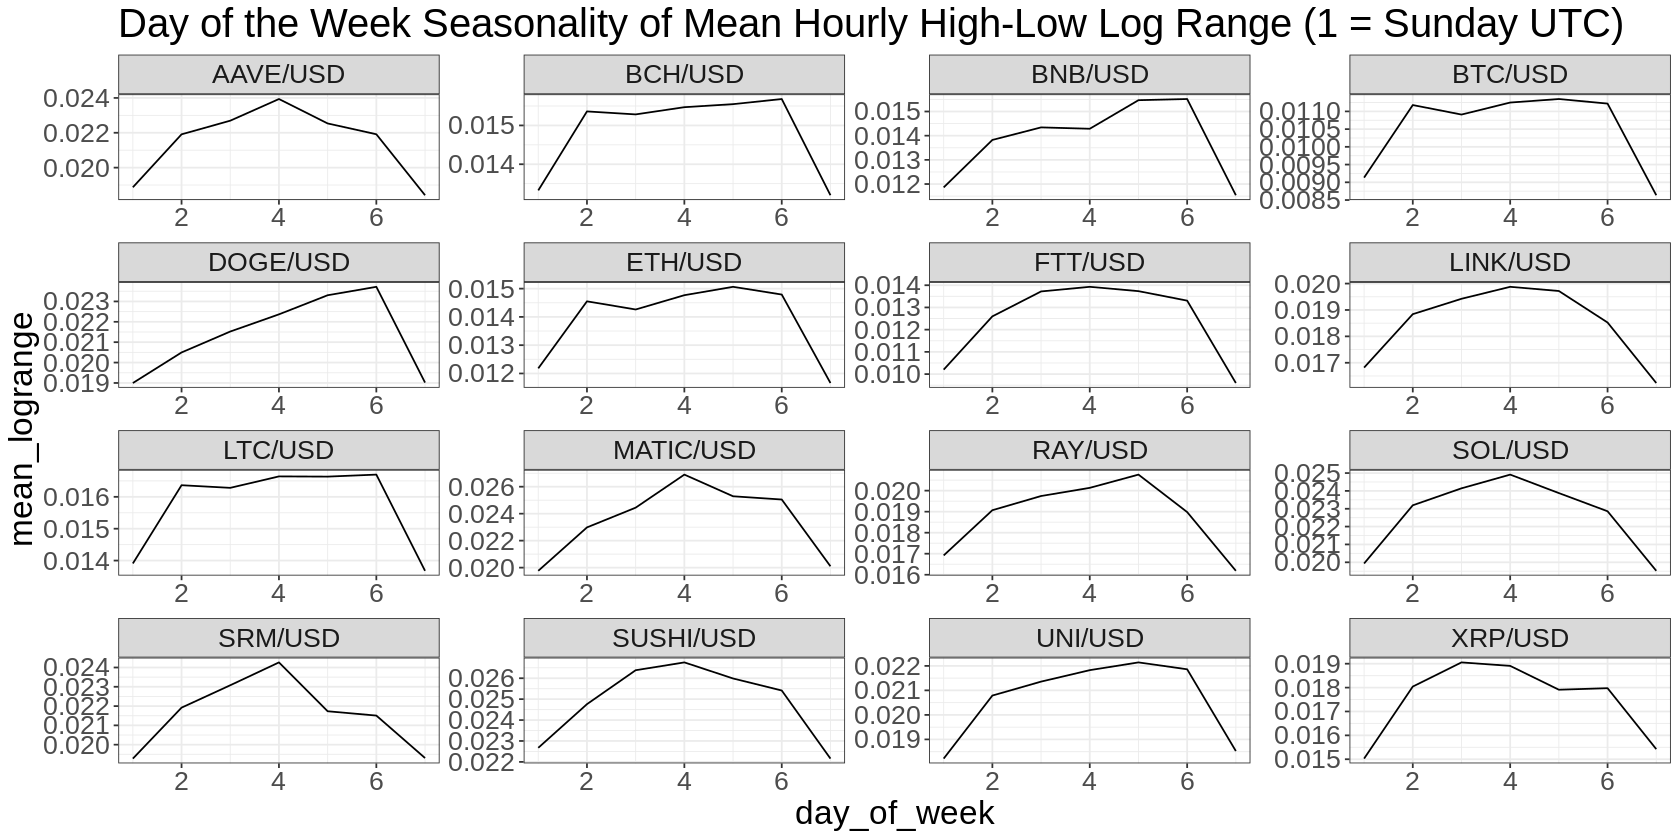

In [17]:
dow_seasonality %>%
  filter(ticker %in% universe) %>%
  group_by(ticker, day_of_week) %>%
  summarise(mean_logrange = mean(logrange)) %>%
  ggplot(aes(x=day_of_week, y=mean_logrange)) +
  geom_line() +
  ggtitle('Day of the Week Seasonality of Mean Hourly High-Low Log Range (1 = Sunday UTC)') +
  facet_wrap(~ticker, scales='free')

# Dumb Day of Week Seasonality Strategy - Ape Long BTC and ETH Monday Weds Friday

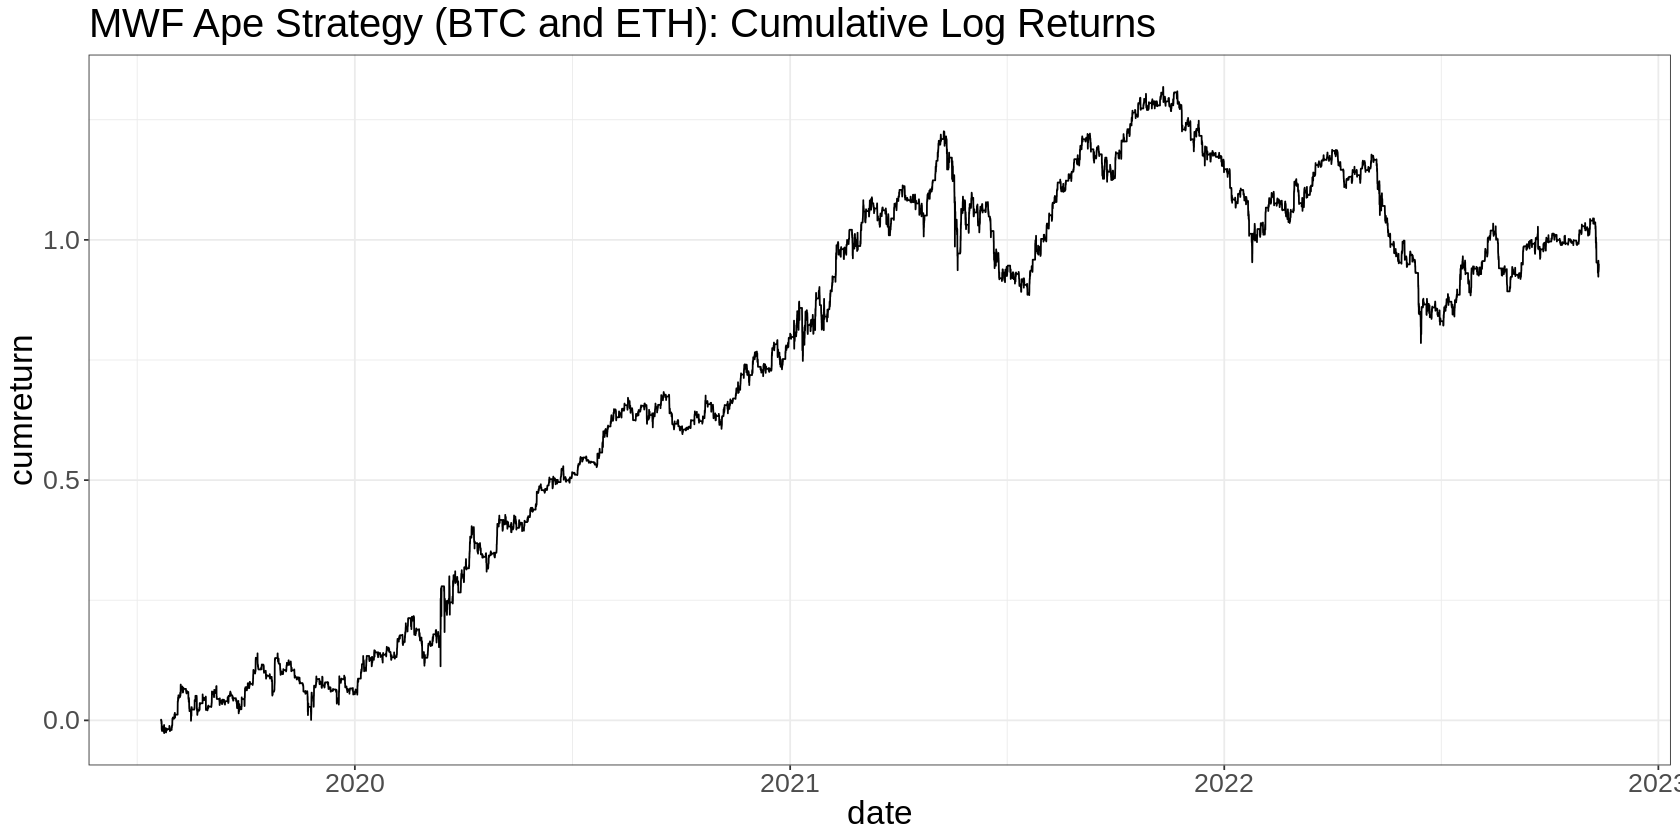

In [18]:
spot %>%
  filter(ticker %in% c('BTC/USD','ETH/USD')) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    day_of_week = factor(lubridate::wday(date)), 
    c2c_simplereturn = close / lag(close) - 1,
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  mutate(strat_return = case_when(day_of_week %in% c(2,4,6) ~ c2c_simplereturn, TRUE ~ 0)) %>%
  group_by(date) %>%
  summarise(strat_logreturn = log(mean(strat_return / 2) + 1)) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(strat_logreturn)) %>%
  ggplot(aes(x=date, y=cumreturn)) +
    geom_line() +
    ggtitle('MWF Ape Strategy (BTC and ETH): Cumulative Log Returns')
  

# What do returns look like as a function of the time from their FTX listing?

We've observed pump-o-rama effects on FTX listings

In [19]:
# remove assets that existed prior to 2021
remove_assets <- spot %>%
  filter(date == '2020-12-31') %>%
  group_by(ticker) %>%
  summarise(count = n())

ape <- spot %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    hours_from_listing = row_number(),
    logreturns = log(close / lag(close))
  ) %>%
  na.omit() %>%
  anti_join(remove_assets, by = 'ticker')

Do we have enough data?

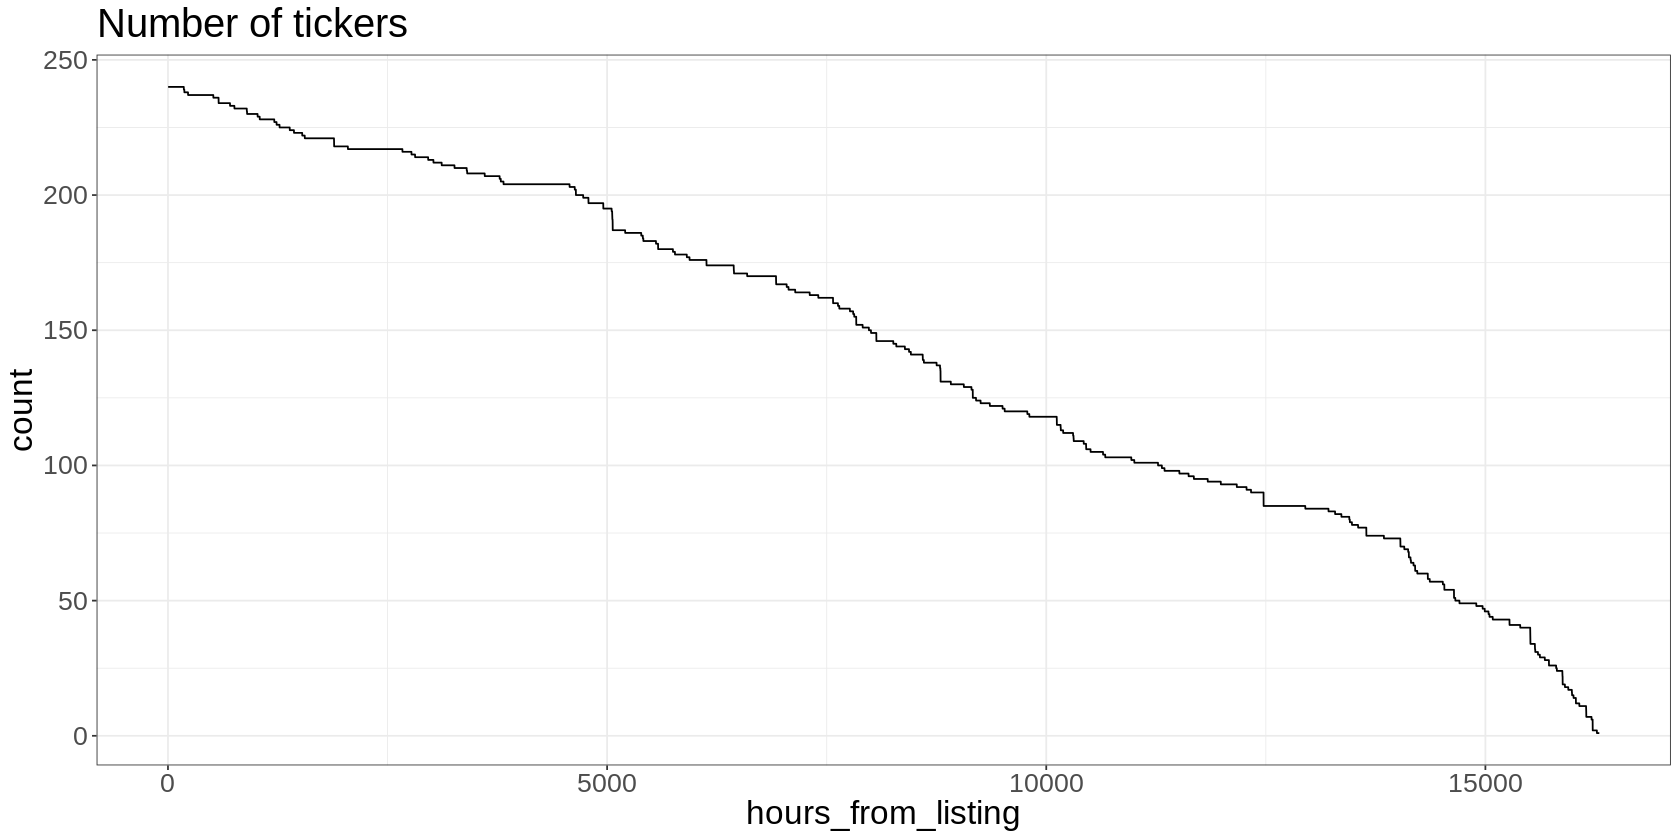

In [20]:
ape %>%
  group_by(hours_from_listing) %>%
  summarise(count = n()) %>%
  ggplot(aes(x=hours_from_listing, y=count)) + geom_line() + ggtitle('Number of tickers')

Let's plot cumulative return as a function of the hours from the listing.

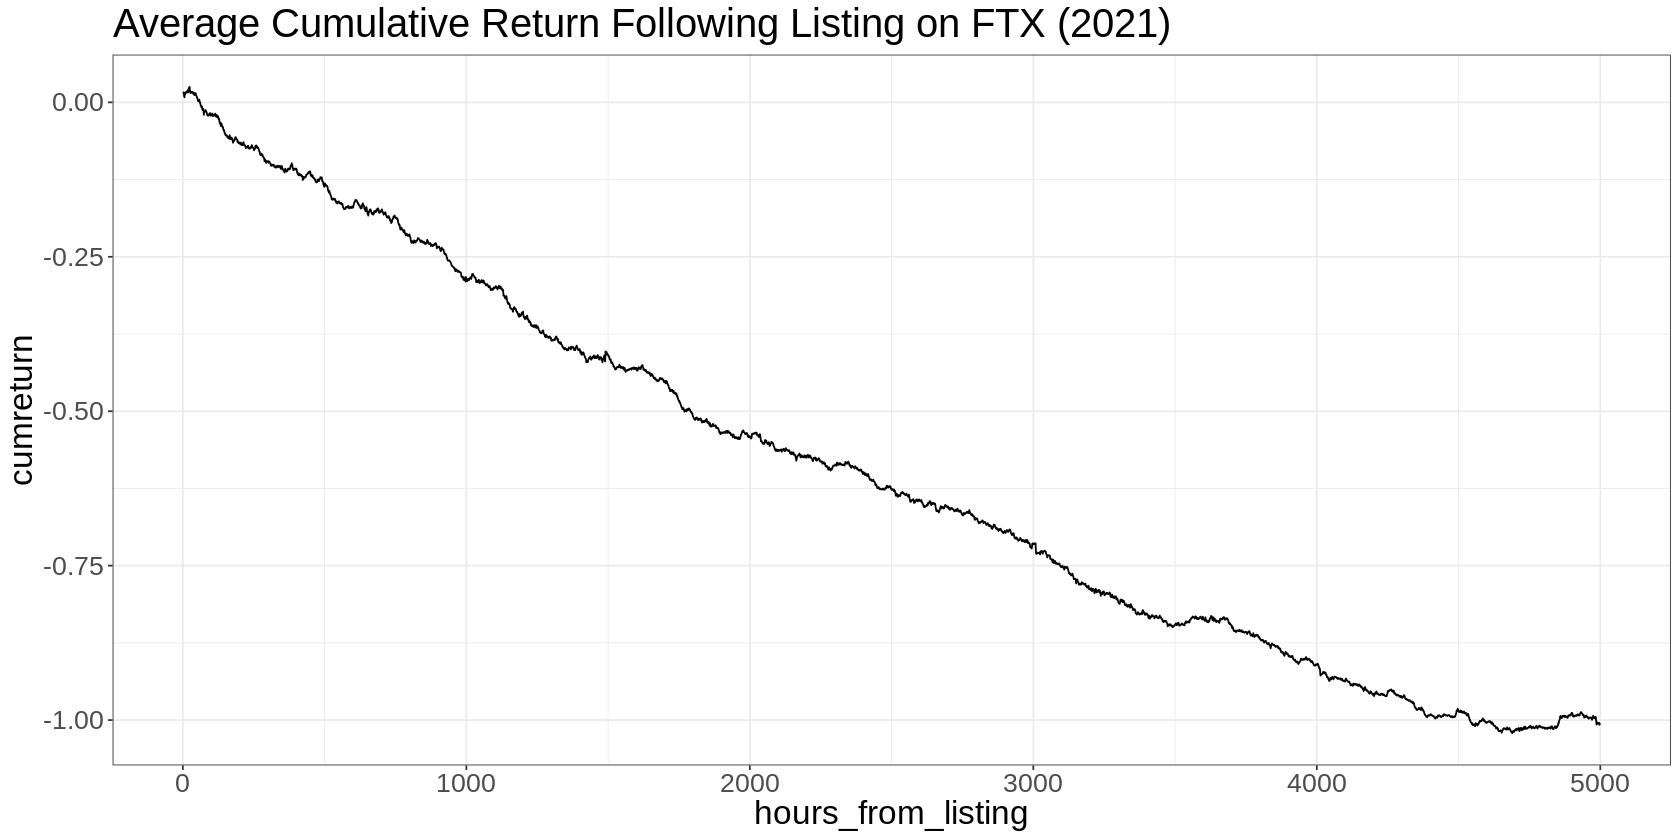

In [21]:
ape %>%
  group_by(hours_from_listing) %>%
  summarise(meanreturn = mean(logreturns)) %>%
  arrange(hours_from_listing) %>%
  mutate(cumreturn = cumsum(meanreturn)) %>%
  filter(hours_from_listing < 5000) %>%
  ggplot(aes(x=hours_from_listing, y=cumreturn)) + 
    geom_line() +
    ggtitle('Average Cumulative Return Following Listing on FTX (2021)') 

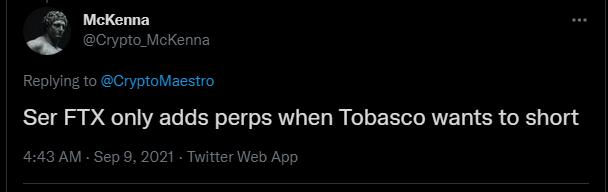

Let's zoom in on first week

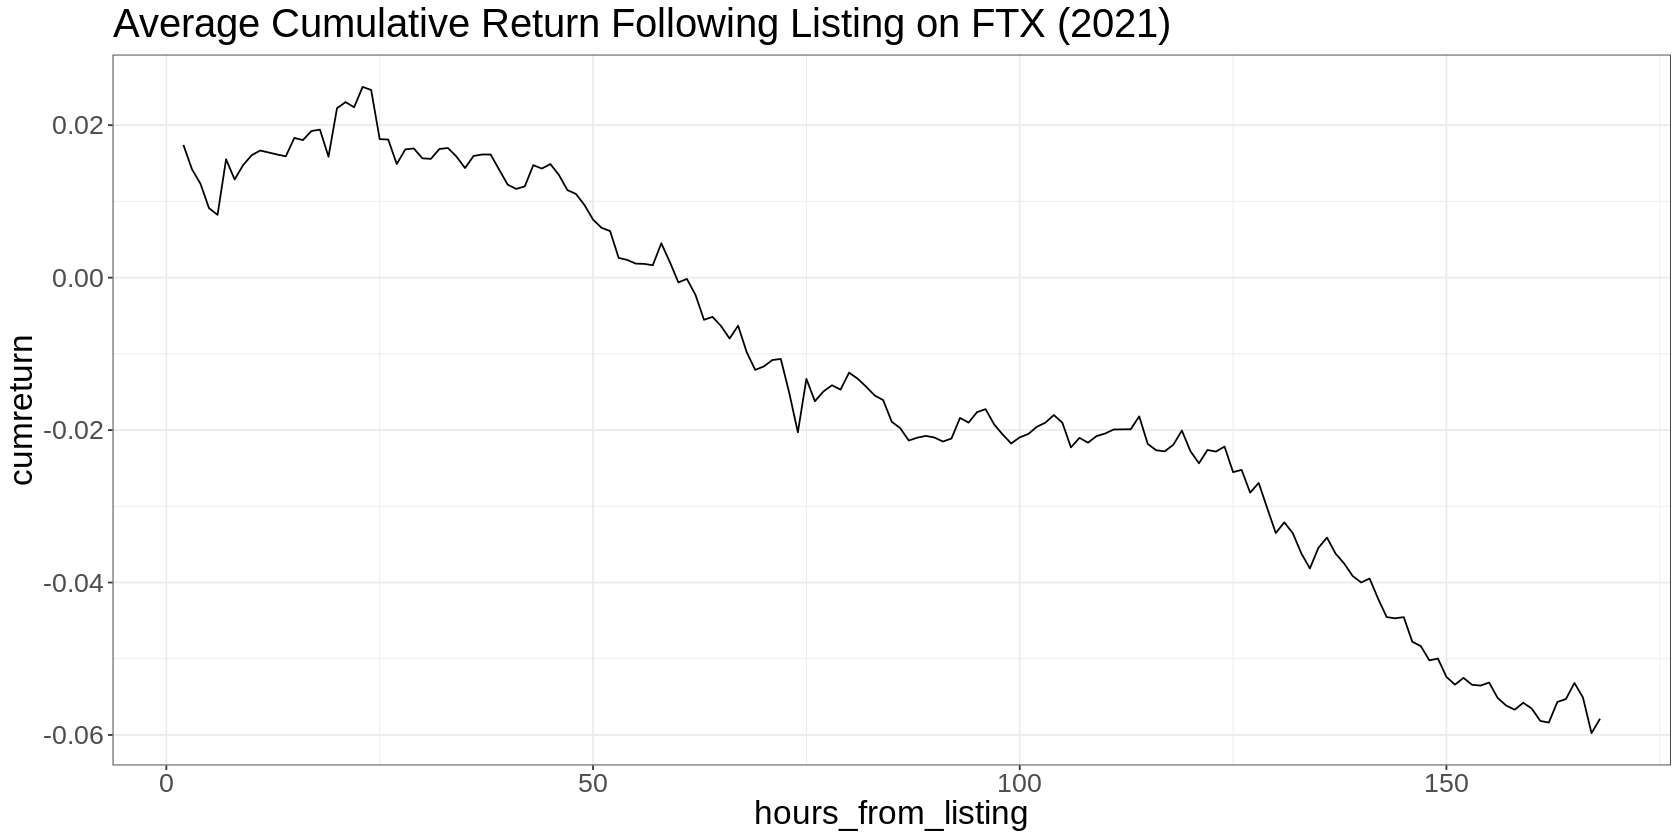

In [22]:
ape %>%
  group_by(hours_from_listing) %>%
  summarise(meanreturn = mean(logreturns)) %>%
  arrange(hours_from_listing) %>%
  mutate(cumreturn = cumsum(meanreturn)) %>%
  filter(hours_from_listing <= 168) %>%
  ggplot(aes(x=hours_from_listing, y=cumreturn)) + 
    geom_line() +
    ggtitle('Average Cumulative Return Following Listing on FTX (2021)') 

High returns first couple of hour or so (remember the first it's close to close)

Suggests, at least on average that something like the following is not as dumb as it might seem:
 - Ape into any new listing
 - Reverse short 2 days later.

I'm interested to see how persistent this is effect across the assets... TBC.

# Basis as a Predictor of Future Spot Returns

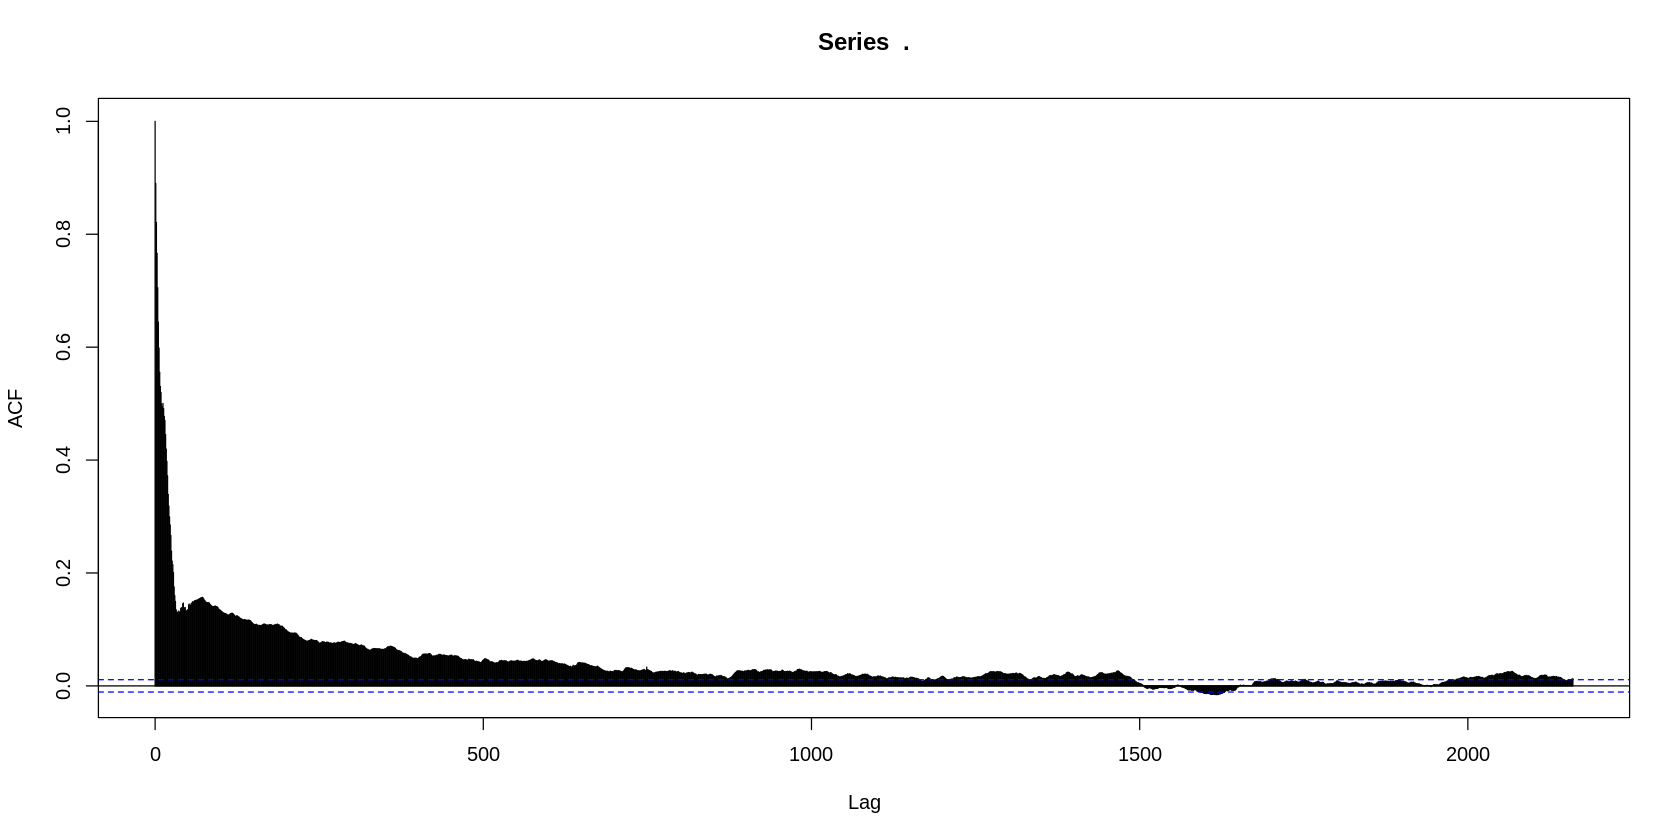

In [23]:
funding %>%
  filter(ticker %in% 'BTC-PERP') %>% 
  arrange(date) %>%
  pull(rate) %>%
  acf(lag.max = 90*24)

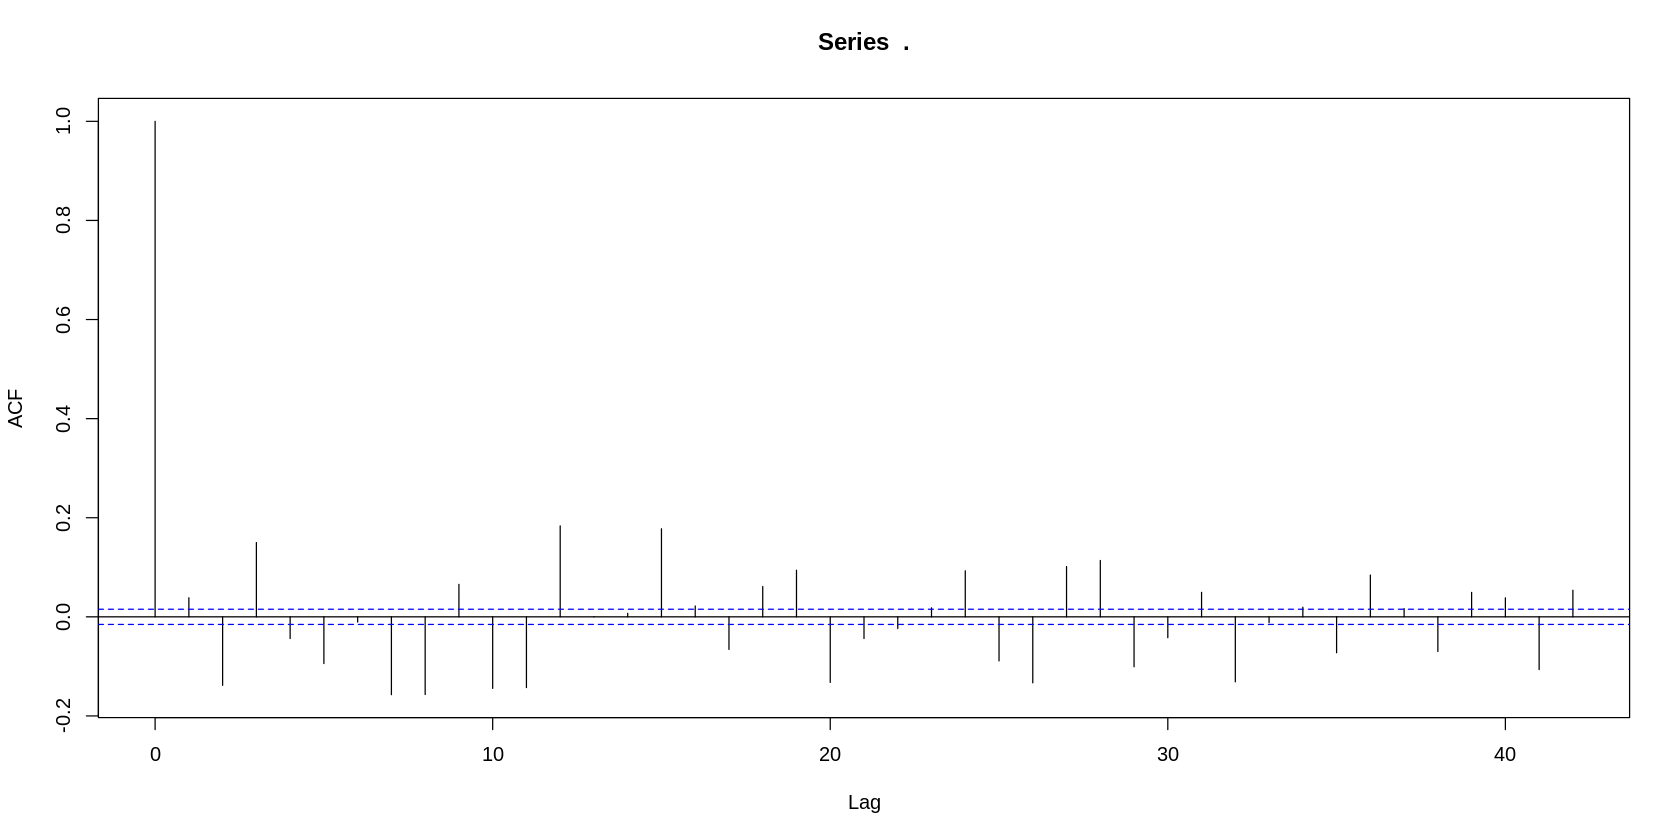

In [24]:
funding %>%
  filter(ticker == 'BTC-PERP') %>%
  filter(date >= '2021-01-01') %>%
  arrange(date) %>%
  pull(rate) %>%
  diff() %>%
  acf()

`geom_smooth()` using formula = 'y ~ x'


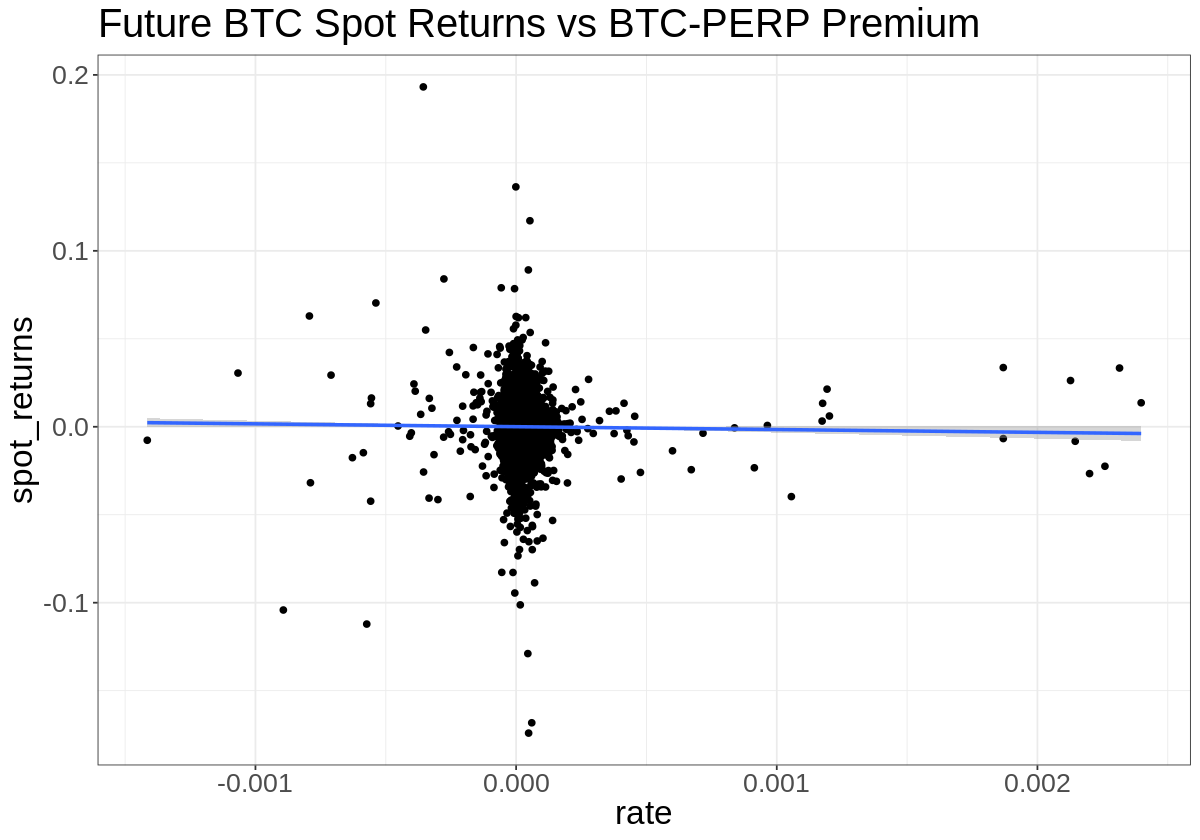

In [25]:
options(repr.plot.width = 10, repr.plot.height=7)

spot %>%
  filter(ticker == 'BTC/USD') %>%
  inner_join(funding %>% filter(ticker == 'BTC-PERP'), by = 'date') %>%
  mutate(spot_returns = log(close/open)) %>%
  ggplot(aes(x=rate, y=spot_returns)) + 
    geom_point() + 
    geom_smooth(method='lm') + 
    ggtitle('Future BTC Spot Returns vs BTC-PERP Premium')
